# **Red neuronal convolucional para el diagnóstico de nódulos tiroideos según la clasificación EU-TIRADS**

## Por Alejandro Martínez Hernández

### Notebook 2/3

# Notas artículo profe

- **Ajuste del tamaño del lote:** Pequeños tamaños de lote tienden a funcionar mejor en situaciones de desbalance de clases, ya que ayudan a evitar el sobreajuste en la clase mayoritaria y mejoran la generalización.

- **Aumento de datos (Data Augmentation):** Implementar políticas de aumento de datos puede tener un impacto amplificado bajo condiciones de desbalance de clases, especialmente en la precisión de las clases minoritarias. Estrategias como flips horizontales, recortes aleatorios, y técnicas más sofisticadas como AugMix y AutoAugment pueden ser particularmente útiles.

- **Arquitecturas grandes y pre-entrenamiento:** Las arquitecturas más grandes tienden a sobreajustarse en conjuntos de datos desbalanceados, mientras que el pre-entrenamiento, especialmente el auto-supervisado, puede mejorar la representación de características y aumentar el rendimiento general. Este último es robusto a desequilibrios en los datos de entrenamiento y puede ser especialmente beneficioso.

- **Minimización Consciente de la Nitidez (Sharpness-Aware Minimization, SAM):** Modificar el SAM para aumentar la "planitud" en los términos de pérdida de las clases minoritarias puede mejorar la precisión de estos grupos al alejar los límites de decisión de las muestras minoritarias.
Suavizado de etiquetas (Label Smoothing): Aplicar suavizado de etiquetas, especialmente en ejemplos de clases minoritarias, puede prevenir el sobreajuste.

# **Procesamiento de datos**

Ya conociendo la estructura de los datos, estos deben ser preparados y nuevamente organizados para poder usarlos en algún entrenamiento de un modelo. 


## **Creación de directorios**

En la carpeta "organized" se crean otras carpetas para almacenar las imágenes (\images) y anotaciones (\notes) correspondientes que se van a usar para el entrenamiento.

Dentro de estas carpetas habrán otras que contendrán las imágenes y anotaciones crudas (\Raw) y otra para las imagenes y anotaciones ya procesadas (cropped).

In [1]:
import os
import shutil

def crear_subcarpetas(carpeta_principal, subcarpetas, subcarpeta_padre=None):
    """
    Crea subcarpetas dentro de una carpeta principal. Si se especifica una subcarpeta_padre,
    las subcarpetas se crearán dentro de esta.
    
    Parámetros:
    carpeta_principal (str): Ruta de la carpeta principal.
    subcarpetas (list): Lista de nombres de subcarpetas a crear.
    subcarpeta_padre (str): Nombre de la subcarpeta dentro de la cual se crearán nuevas subcarpetas.
    """
    # Determinar la ruta base donde se crearán las subcarpetas
    ruta_base = carpeta_principal if subcarpeta_padre is None else os.path.join(carpeta_principal, subcarpeta_padre)
    
    # Asegurar que la ruta base exista
    if not os.path.exists(ruta_base):
        os.makedirs(ruta_base)
    
    # Crear cada subcarpeta
    for subcarpeta in subcarpetas:
        os.makedirs(os.path.join(ruta_base, subcarpeta), exist_ok=True)

# Aplicación de función
carpeta_principal_1 = 'db_unal'
carpeta_principal_2 = 'db_unal/organized'
carpeta_principal_3 = 'db_unal/organized/images'
carpeta_principal_4 = 'db_unal/organized/notes'

subcarpetas_dentro_v1 = ['images', 'notes']  
subcarpetas_dentro_v2 = ['raw', 'cropped'] 
subcarpetas_dentro_v3 = ['high', 'low']   


# Crear subcarpetas adicionales dentro de db_unal/organized
crear_subcarpetas(carpeta_principal_1, subcarpetas_dentro_v1, 'organized')
crear_subcarpetas(carpeta_principal_2, subcarpetas_dentro_v2, 'images')
crear_subcarpetas(carpeta_principal_3, subcarpetas_dentro_v3, 'raw')
crear_subcarpetas(carpeta_principal_3, subcarpetas_dentro_v3, 'cropped')
crear_subcarpetas(carpeta_principal_4, subcarpetas_dentro_v3, 'raw')
crear_subcarpetas(carpeta_principal_4, subcarpetas_dentro_v3, 'cropped')

## **Importar los datos**

Se trae el dataframe *df_agrupado.csv* que se generó en el notebook *1_exploracion_datos.ipynb*

In [2]:
import pandas as pd
import os

def cargar_csv_de_forma_segura(ruta_archivo):
    """
    Carga un archivo CSV en un DataFrame de pandas de manera segura.
    
    Parámetros:
    ruta_archivo (str): La ruta completa al archivo CSV que se desea cargar.
    
    Retorna:
    DataFrame: Un DataFrame de pandas con los datos cargados desde el archivo CSV.
    None: Retorna None si ocurre un error durante la carga del archivo.
    """
    # Verificar si el archivo existe
    if not os.path.exists(ruta_archivo):
        print(f"El archivo {ruta_archivo} no existe.")
        return None
    
    try:
        # Usar pandas para leer el archivo CSV
        df = pd.read_csv(ruta_archivo)
        return df
    except pd.errors.EmptyDataError:
        print("El archivo está vacío.")
    except pd.errors.ParserError:
        print("Error al parsear el archivo CSV.")
    except Exception as e:
        print(f"Error al cargar el archivo: {e}")
    
    return None

# Cargar el archivo
ruta_archivo = 'df_agrupado.csv'
df_agrupado = cargar_csv_de_forma_segura(ruta_archivo)

# Mostar dataframe
df_agrupado



,Paciente,Edad,Sexo,Numero_imagen,TIRADS,Seg_radiologo_1,Seg_residente_1,Seg_residente_2,Composicion,Ecogenicidad,Margenes,Calcificaciones
0,1,NaN,NaN,1_1,high,1,1,0,NaN,NaN,NaN,NaN
1,1,NaN,NaN,1_2,high,1,1,1,NaN,NaN,NaN,NaN
2,2,49.0,F,2_1,high,1,1,1,solid,hyperechogenicity,well defined,NaN
3,3,31.0,F,3_1,high,1,1,1,spongiform,isoechogenicity,well defined,microcalcifications
4,4,37.0,F,4_1,low,1,1,1,spongiform,isoechogenicity,well defined,microcalcifications
...,...,...,...,...,...,...,...,...,...,...,...,...
167,146,NaN,NaN,146_1,low,1,1,0,NaN,NaN,NaN,NaN
168,147,NaN,NaN,147_1,high,1,1,0,NaN,NaN,NaN,NaN
169,148,37.0,F,148_1,high,1,1,0,solid,hypoechogenicity,well defined,NaN
170,149,78.0,M,149_1,high,1,1,0,NaN,NaN,NaN,NaN


Ya que se importó la base de datos que indica que imágenes y anotaciones se van a usar, se generará una copia de cada uno de estos a las carpetas \raw dentro de \organized.

In [3]:
import pandas as pd
import os
import shutil

ruta_origen = "db_unal/originals/DDTI_V1"
ruta_destino_base = "db_unal/organized/images/raw"

for index, row in df_agrupado.iterrows():
    nombre_imagen = row['Numero_imagen'] + '.jpg'  # Asumiendo que los nombres en el DataFrame no incluyen '.jpg'
    tirads_categoria = row['TIRADS'].lower()  # Asegurándonos de que el nombre del directorio esté en minúsculas

    # Construir la ruta completa del archivo de origen
    archivo_origen = os.path.join(ruta_origen, nombre_imagen)

    # Construir la ruta completa del archivo de destino
    ruta_destino = os.path.join(ruta_destino_base, tirads_categoria, nombre_imagen)

    # Verificar si el archivo existe antes de intentar copiarlo
    if os.path.exists(archivo_origen):
        # Crear el directorio destino si no existe
        os.makedirs(os.path.dirname(ruta_destino), exist_ok=True)
        # Copiar el archivo
        shutil.copy(archivo_origen, ruta_destino)
    else:
        print(f"No se encontró el archivo {archivo_origen}")

## **Recortar las imágenes**

Para comparar el procesamiento de las imágenes y centrarse en solo el ultrasonido, se realiza un recorte tratando de identificar los bordes.

In [4]:
import cv2
import os


def ajustar_niveles(imagen, nivel_min, nivel_max):
    """
    Ajusta los niveles de brillo y contraste de una imagen.

    Parameters:
    imagen (ndarray): Imagen de entrada en formato de numpy array.
    nivel_min (int): Valor mínimo del rango de salida.
    nivel_max (int): Valor máximo del rango de salida.

    Returns:
    ndarray: Imagen con los niveles ajustados.
    """
    return cv2.normalize(imagen, None, alpha=nivel_min, beta=nivel_max, norm_type=cv2.NORM_MINMAX)

def encontrar_y_recortar_imagen(input_path, output_path):
    """
    Encuentra la región de interés en una imagen de ultrasonido y la recorta,
    manteniendo los niveles originales de brillo y contraste.

    Parameters:
    input_path (str): Ruta de la imagen de entrada.
    output_path (str): Ruta donde se guardará la imagen recortada.
    """
    imagen_original = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)
    imagen_gris = cv2.cvtColor(imagen_original, cv2.COLOR_BGR2GRAY)
    imagen_contrastada = ajustar_niveles(imagen_gris, 0, 255)
    _, imagen_binaria = cv2.threshold(imagen_contrastada, 1, 255, cv2.THRESH_BINARY)
    contornos, _ = cv2.findContours(imagen_binaria, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contorno in contornos:
        x, y, ancho, alto = cv2.boundingRect(contorno)
        borde_mas_corto = min(ancho, alto)
        borde_mas_largo = max(ancho, alto)
        proporcion = borde_mas_largo / borde_mas_corto

        if borde_mas_corto >= 100 and proporcion <= 2.5:
            imagen_recortada = imagen_original[y:y+alto, x:x+ancho]
            cv2.imwrite(output_path, imagen_recortada)
            break

def ubicar(input_folder, output_folder):
    """
    Procesa todas las imágenes en un directorio, recortando regiones de interés
    según especificado en `encontrar_y_recortar_imagen`.

    Parameters:
    input_folder (str): Directorio que contiene las imágenes de entrada.
    output_folder (str): Directorio donde se guardarán las imágenes recortadas.
    """
    for filename in os.listdir(input_folder):
        try:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                input_path = os.path.join(input_folder, filename)
                base_name = filename.rsplit('.', 1)[0] + '.jpg'
                output_path = os.path.join(output_folder, base_name)
                
                try:
                    encontrar_y_recortar_imagen(str(input_path), str(output_path))
                except Exception as e:
                    print(f"No se pudo procesar el archivo {filename}: {e}")
        except Exception as e:
            print(f"Error al manejar el archivo {filename}: {e}")



# high
input_folder_1 = 'db_unal/organized/images/raw/high'
output_folder_1 = 'db_unal/organized/images/cropped/high'

# low
input_folder_3 = 'db_unal/organized/images/raw/low'
output_folder_3 = 'db_unal/organized/images/cropped/low'


# Procesar imágenes
ubicar(input_folder_1, output_folder_1)
ubicar(input_folder_3, output_folder_3)

### **Ejemplos de las imágenes recortadas**

Una vez recortadas y organizadas, estas serán las imágenes que se analizarán

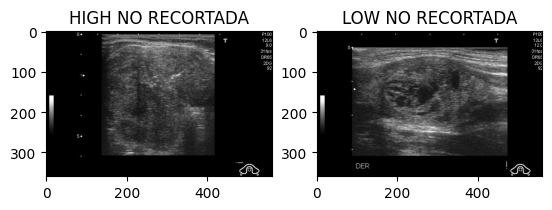

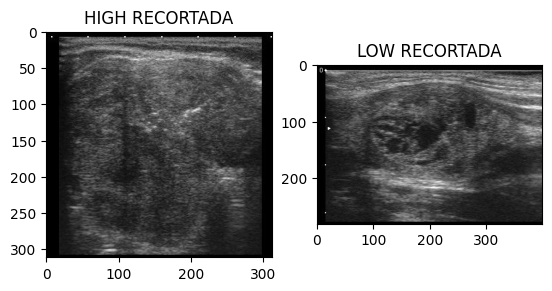

In [32]:
import cv2
import matplotlib.pyplot as plt


# IMÁGENES NO RECORTADAS
# Fijar la dirección de cualquiera de las dos imágenes
folder_1 = 'db_unal/organized/images/raw/high/1_1.jpg' 
folder_2 = 'db_unal/organized/images/raw/low/4_1.jpg'

# Leer las direcciones con cv2
img_high = cv2.imread(folder_1)
img_low = cv2.imread(folder_2)

# Convertir el perfil de color de BGR a RGB
img_high_rgb = cv2.cvtColor(img_high, cv2.COLOR_BGR2RGB)
img_low_rgb = cv2.cvtColor(img_low, cv2.COLOR_BGR2RGB)

# Crear figura y subfiguras
plt.figure()
plt.subplot(1,2,1)
plt.title('HIGH NO RECORTADA')
plt.imshow(img_high_rgb)
plt.subplot(1,2,2)
plt.title('LOW NO RECORTADA')
plt.imshow(img_low_rgb)
plt.show()

#_________________________________________________________

# IMÁGENES RECORTADAS
# Fijar la dirección de cualquiera de las dos imágenes
folder_1 = 'db_unal/organized/images/cropped/high/1_1.jpg' 
folder_2 = 'db_unal/organized/images/cropped/low/4_1.jpg'

# Leer las direcciones con cv2
img_high = cv2.imread(folder_1)
img_low = cv2.imread(folder_2)

# Convertir el perfil de color de BGR a RGB
img_high_rgb = cv2.cvtColor(img_high, cv2.COLOR_BGR2RGB)
img_low_rgb = cv2.cvtColor(img_low, cv2.COLOR_BGR2RGB)

# Crear figura y subfiguras
plt.figure()
plt.subplot(1,2,1)
plt.title('HIGH RECORTADA')
plt.imshow(img_high_rgb)
plt.subplot(1,2,2)
plt.title('LOW RECORTADA')
plt.imshow(img_low_rgb)
plt.show()

# **Creación de modelos**

PAra la siguiente parte se crearan los siguientes modelos de clasificación simple:
- SVM con crossvalidation y gridsearch para buscar parámetros.
- SVM con preprocesamiento de datos con PCA, crossvalidation y gridsearch para buscar parámetros.
- Forest con crossvalidation y gridsearch para buscar parámetros.
- Forest con preprocesamiento de datos con PCA, crossvalidation y gridsearch para buscar parámetros.

## **SVM**

### **Crossvalidation + GridSearch**


In [33]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV

# Ruta relativa a la carpeta que contiene las imágenes organizadas por etiquetas
data_dir = "db_unal/organized/images/cropped"
categories = ['high', 'low']

# Listas para almacenar los datos de las imágenes y sus etiquetas
data = []
labels = []

# Cargar las imágenes y las etiquetas desde las carpetas
for category in categories:
    path = os.path.join(data_dir, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = cv2.imread(img_path)
        if image is not None:
            # Convertir imagen a escala de grises y redimensionar
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image, (128, 128))
            # Aplanar la imagen para crear un vector de características
            flattened_image = image.flatten()
            data.append(flattened_image)
            labels.append(category)

# Convertir las listas de datos y etiquetas en arrays de numpy
data = np.array(data)
labels = np.array(labels)

# Parámetros para GridSearch
param_grid = {
    'C': [0.1, 1, 10, 100],  # valores de C
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001, 0.0001],  # valores de gamma
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']  # tipos de kernel
}

# Crear el modelo SVM
svm_model = svm.SVC()

# Configuración de GridSearchCV
grid_search = GridSearchCV(svm_model, param_grid, cv=5, verbose=1, scoring='accuracy')

# Ejecutar GridSearch
grid_search.fit(data, labels)

# Mejor modelo y parámetros
print("Mejor modelo:", grid_search.best_estimator_)
print("Mejor conjunto de parámetros:", grid_search.best_params_)
print("Mejor puntuación de validación cruzada:", grid_search.best_score_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Mejor modelo: SVC(C=0.1, kernel='linear')
Mejor conjunto de parámetros: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Mejor puntuación de validación cruzada: 0.6100840336134454


### **PCA + Crossvalidation + GridSearch**

En este código, se han modificado varias partes del anterior para incluir PCA:

- **Pipeline de sklearn:** Utiliza Pipeline para encadenar PCA y SVM. Esto garantiza que PCA se aplique a los datos antes de que se pase a SVM en cada iteración del proceso de entrenamiento y validación cruzada.

- **Parámetros de GridSearch:** Se actualizó param_grid para ajustarlo al pipeline, especificando que los parámetros se apliquen al estimador SVM dentro del pipeline (notado por el prefijo 'svm__' en los nombres de los parámetros).

In [34]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

# Ruta relativa a la carpeta que contiene las imágenes organizadas por etiquetas
data_dir = "db_unal/organized/images/cropped"
categories = ['high', 'low']

# Listas para almacenar los datos de las imágenes y sus etiquetas
data = []
labels = []

# Cargar las imágenes y las etiquetas desde las carpetas
for category in categories:
    path = os.path.join(data_dir, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = cv2.imread(img_path)
        if image is not None:
            # Convertir imagen a escala de grises y redimensionar
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image, (128, 128))
            # Aplanar la imagen para crear un vector de características
            flattened_image = image.flatten()
            data.append(flattened_image)
            labels.append(category)

# Convertir las listas de datos y etiquetas en arrays de numpy
data = np.array(data)
labels = np.array(labels)

# Definir el número de componentes para PCA
n_components = 50  # Este valor puede ser ajustado según la varianza a conservar

# Crear un pipeline que incluya PCA y SVM
pipeline = Pipeline([
    ('pca', PCA(n_components=n_components)),
    ('svm', svm.SVC())
])

# Parámetros para GridSearch
param_grid = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': ['scale', 'auto', 0.1, 0.01, 0.001, 0.0001],
    'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

# Configuración de GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, scoring='accuracy')

# Ejecutar GridSearch
grid_search.fit(data, labels)

# Mejor modelo y parámetros
print("Mejor modelo:", grid_search.best_estimator_)
print("Mejor conjunto de parámetros:", grid_search.best_params_)
print("Mejor puntuación de validación cruzada:", grid_search.best_score_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


## **Random Forest**

### **Crossvalidation + GridSearch**

In [1]:
import os
import cv2
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Ruta relativa a la carpeta que contiene las imágenes organizadas por etiquetas
data_dir = "db_unal/organized/images/cropped"
categories = ['high', 'low']

# Listas para almacenar los datos de las imágenes y sus etiquetas
data = []
labels = []

# Cargar las imágenes y las etiquetas desde las carpetas
for category in categories:
    path = os.path.join(data_dir, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = cv2.imread(img_path)
        if image is not None:
            # Convertir imagen a escala de grises y redimensionar
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image, (128, 128))
            # Aplanar la imagen para crear un vector de características
            flattened_image = image.flatten()
            data.append(flattened_image)
            labels.append(category)

# Convertir las listas de datos y etiquetas en arrays de numpy
data = np.array(data)
labels = np.array(labels)

# Parámetros para GridSearch
param_grid = {
    'n_estimators': [10, 50, 100, 200],  # Número de árboles en el bosque
    'max_features': ['auto', 'sqrt', 'log2'],  # Número de características a considerar al buscar la mejor división
    'max_depth': [None, 10, 20, 30, 40],  # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],  # Número mínimo de muestras requeridas para dividir un nodo
    'min_samples_leaf': [1, 2, 4],  # Número mínimo de muestras requeridas en cada hoja del árbol
    'bootstrap': [True, False]  # Método para muestrear puntos de datos (con o sin reemplazo)
}

# Crear el modelo de Random Forest
forest_model = RandomForestClassifier()

# Configuración de GridSearchCV
grid_search = GridSearchCV(forest_model, param_grid, cv=5, verbose=1, scoring='accuracy')

# Ejecutar GridSearch
grid_search.fit(data, labels)

# Mejor modelo y parámetros
print("Mejor modelo:", grid_search.best_estimator_)
print("Mejor conjunto de parámetros:", grid_search.best_params_)
print("Mejor puntuación de validación cruzada:", grid_search.best_score_)

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits


KeyboardInterrupt: 

### **PCA + Crossvalidation + GridSearch**

In [ ]:
import os
import cv2
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Ruta relativa a la carpeta que contiene las imágenes organizadas por etiquetas
data_dir = "db_unal/organized/images/cropped"
categories = ['high', 'low']

# Listas para almacenar los datos de las imágenes y sus etiquetas
data = []
labels = []

# Cargar las imágenes y las etiquetas desde las carpetas
for category in categories:
    path = os.path.join(data_dir, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = cv2.imread(img_path)
        if image is not None:
            # Convertir imagen a escala de grises y redimensionar
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image, (128, 128))
            # Aplanar la imagen para crear un vector de características
            flattened_image = image.flatten()
            data.append(flattened_image)
            labels.append(category)

# Convertir las listas de datos y etiquetas en arrays de numpy
data = np.array(data)
labels = np.array(labels)

# Definir el número de componentes principales para PCA
n_components = 50

# Crear un pipeline que incluya PCA y Random Forest
pipeline = Pipeline([
    ('pca', PCA(n_components=n_components)),
    ('forest', RandomForestClassifier())
])

# Parámetros para GridSearch
param_grid = {
    'forest__n_estimators': [10, 50, 100, 200],
    'forest__max_features': ['auto', 'sqrt', 'log2'],
    'forest__max_depth': [None, 10, 20, 30, 40],
    'forest__min_samples_split': [2, 5, 10],
    'forest__min_samples_leaf': [1, 2, 4],
    'forest__bootstrap': [True, False]
}

# Configuración de GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, scoring='accuracy')

# Ejecutar GridSearch
grid_search.fit(data, labels)

# Mejor modelo y parámetros
print("Mejor modelo:", grid_search.best_estimator_)
print("Mejor conjunto de parámetros:", grid_search.best_params_)
print("Mejor puntuación de validación cruzada:", grid_search.best_score_)

## **Naive Bayes**

### **Crossvalidation + GridSearch**

### **PCA + Crossvalidation + GridSearch**

## **MobileNetV3**

### **Small Version**
#### **Adam Optimizer**

Found 138 images belonging to 2 classes.
Found 34 images belonging to 2 classes.
Epoch 1/30


c:\Users\alema\Desktop\paper\thyroid_nodules\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.4808 - loss: 1.1814 - val_accuracy: 0.5588 - val_loss: 0.7058
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 319ms/step - accuracy: 0.5357 - loss: 0.6775 - val_accuracy: 0.4412 - val_loss: 0.6539
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 361ms/step - accuracy: 0.5149 - loss: 0.7011 - val_accuracy: 0.4412 - val_loss: 0.7310
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 363ms/step - accuracy: 0.6185 - loss: 0.6821 - val_accuracy: 0.5588 - val_loss: 0.7403
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 399ms/step - accuracy: 0.5692 - loss: 0.6918 - val_accuracy: 0.5588 - val_loss: 0.6915
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.4999 - loss: 0.7003 - val_accuracy: 0.4412 - val_loss: 0.7179
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 404ms/step - accuracy: 0.5234 - loss: 0.6947 - val_accuracy: 0.4412 - val_loss: 0.6958
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 425ms/step - accuracy: 0.5094 - loss: 0.6858 - val_accuracy: 0.5588 - val_loss: 0.6670
Epoch

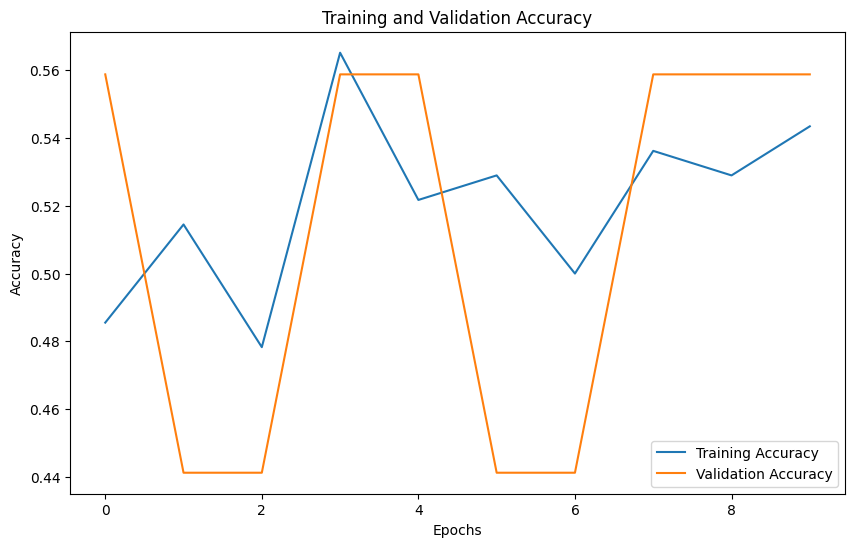

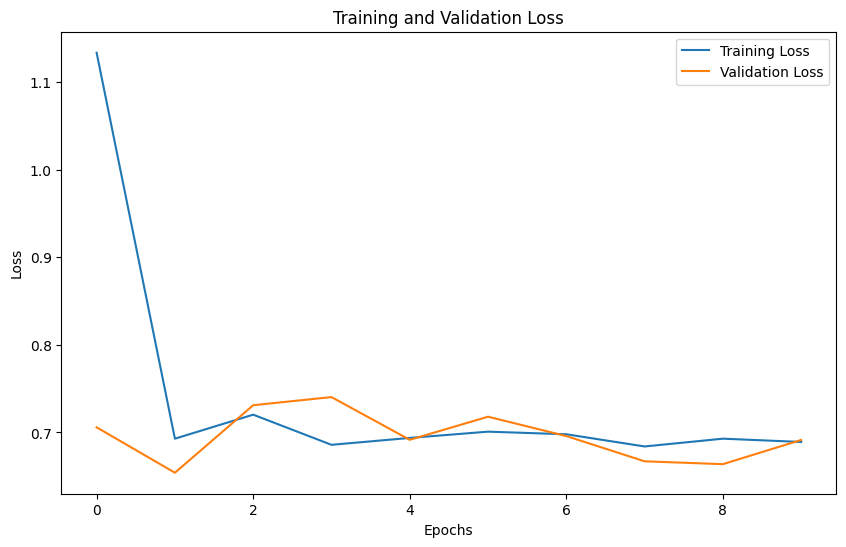

In [30]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Small
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Configurar generadores de imágenes con y sin aumento de datos
def setup_image_generators(base_dir, input_size=(224, 224), batch_size=5):
    """
    Configura generadores de imágenes para entrenamiento y validación.
    
    Args:
    base_dir (str): Directorio base donde están ubicadas las carpetas de imágenes.
    input_size (tuple): Tamaño al cual se redimensionarán las imágenes.
    batch_size (int): Número de imágenes por lote.

    Returns:
    train_generator, validation_generator: Generadores para el entrenamiento y validación.
    """
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        zoom_range=0.2,
        fill_mode='constant',
        rotation_range=40,
        validation_split=0.2  # Reserva el 20% de los datos para validación
    )

    validation_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
    )

    train_generator = train_datagen.flow_from_directory(
        base_dir,
        target_size=input_size,
        #batch_size=batch_size,
        class_mode='binary',
        subset='training'  # Especifica que este generador es para entrenamiento
    )

    validation_generator = validation_datagen.flow_from_directory(
        base_dir,
        target_size=input_size,
        #batch_size=batch_size,
        class_mode='binary',
        subset='validation'  # Especifica que este generador es para validación
    )

    return train_generator, validation_generator

def create_model(input_shape=(224, 224, 3), num_classes=2):
    """
    Crea un modelo de red neuronal secuencial utilizando MobileNetV3 como base.
    
    Args:
    input_shape (tuple): Dimensiones de las imágenes de entrada.
    num_classes (int): Número de clases para la clasificación. Se espera 2 para binaria.

    Returns:
    model: Modelo compilado de TensorFlow.
    """
    base_model = MobileNetV3Small(include_top=False, weights='imagenet', input_shape=input_shape)

    # Congelar el modelo base para reutilizar las características aprendidas en ImageNet
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Cambio para clasificación binaria
    ])

    model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Ruta al directorio de imágenes
base_directory = 'db_unal/organized/images/cropped'
train_gen, val_gen = setup_image_generators(base_directory)

# Crear y compilar el modelo
model = create_model()

# Calcular los pesos de clase para manejar datos desbalanceados
weights = compute_class_weight(
    class_weight='balanced',  # Especifica 'balanced' para ajustar automáticamente en base a la frecuencia de clases
    classes=np.unique(train_gen.classes),  # Obtener clases únicas de los datos de entrenamiento
    y=train_gen.classes)  # Etiquetas de clase reales para cada muestra de entrenamiento

# Crear un diccionario mapeando índices de clase a sus respectivos pesos calculados
class_weights = {i: weights[i] for i in range(len(weights))}

# Configurar el callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitorear la pérdida de validación
    min_delta=0.01,      # Cambio mínimo detectado como una mejora
    patience=8,          # Número de épocas sin mejora después de las cuales el entrenamiento será detenido
    verbose=1,           # Mostrar mensajes de progreso
    mode='min'           # 'min' porque queremos minimizar la pérdida
)

# Entrenar el modelo
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    class_weight=class_weights, # Ajuste de pesos para cada clase
    callbacks=[early_stopping]
)

# Performance Metrics

import matplotlib.pyplot as plt

# Retrieve accuracy results on training and validation data sets for each training epoch.
acc = history.history['accuracy']  # Training accuracy
val_acc = history.history['val_accuracy']  # Validation accuracy

# Retrieve loss results on training and validation data sets for each training epoch.
loss = history.history['loss']  # Training loss
val_loss = history.history['val_loss']  # Validation loss

# Determine the number of epochs, based on the length of the accuracy list.
epochs = range(len(acc))

# Plot training and validation accuracy as a function of epochs.
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')  # Set the title of the graph
plt.xlabel('Epochs')  # Label the x-axis as 'Epochs'
plt.ylabel('Accuracy')  # Label the y-axis as 'Accuracy'
plt.legend()  # Add a legend to distinguish training vs. validation

# Plot training and validation loss as a function of epochs.
plt.figure(figsize=(10, 6))  # Create a new figure for loss visualization
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')  # Set the title of the graph
plt.xlabel('Epochs')  # Label the x-axis as 'Epochs'
plt.ylabel('Loss')  # Label the y-axis as 'Loss'
plt.legend()  # Add a legend to distinguish training vs. validation

#### **SGD optimizer**

Found 138 images belonging to 2 classes.
Found 34 images belonging to 2 classes.
Epoch 1/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5210 - loss: 1.8636 - val_accuracy: 0.4412 - val_loss: 0.7012
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 624ms/step - accuracy: 0.4960 - loss: 0.6971 - val_accuracy: 0.5588 - val_loss: 0.6334
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 500ms/step - accuracy: 0.5361 - loss: 0.6869 - val_accuracy: 0.5588 - val_loss: 0.7201
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 518ms/step - accuracy: 0.5584 - loss: 0.7105 - val_accuracy: 0.5588 - val_loss: 0.7428
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 553ms/step - accuracy: 0.4784 - loss: 0.6991 - val_accuracy: 0.5588 - val_loss: 0.6912
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 525ms/step - accuracy: 0.6136 - loss: 0.6822 - val_accuracy: 0.5588 - val_loss: 0.5981
Epoch 7/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 570ms/step - accuracy: 0.4929 - loss: 0.7195 - val_accuracy: 0.4412 - val_loss: 0.7297
Epoch 8/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 

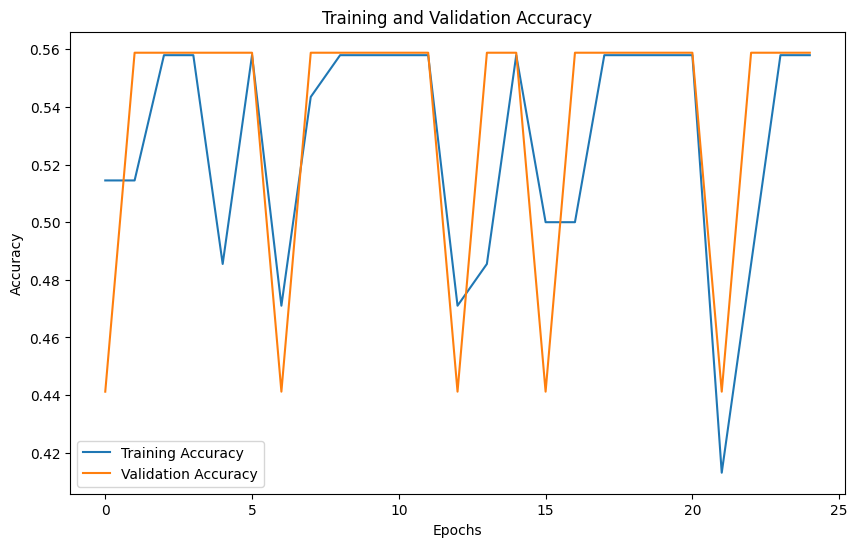

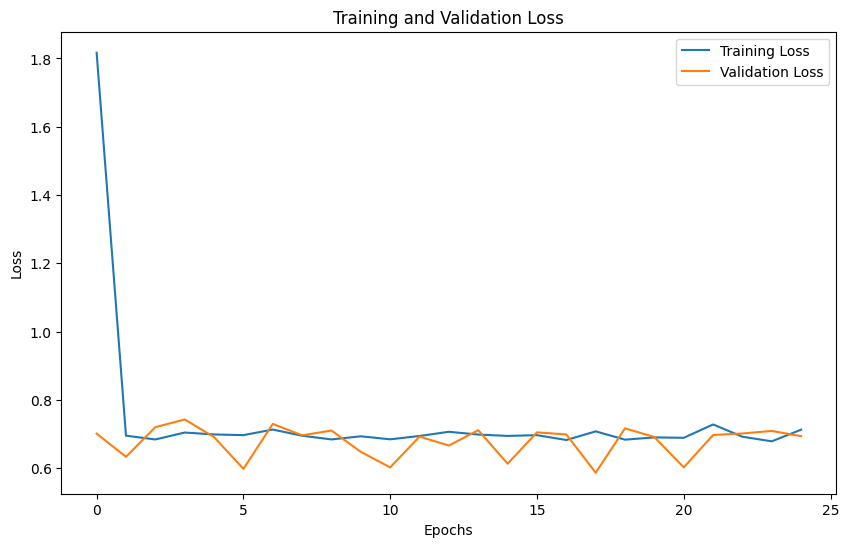

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

# Definir generadores de imágenes con aumento de datos
train_datagen = ImageDataGenerator(
    rescale=1./255,
    #rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    fill_mode='constant',
    validation_split=0.2  # Reservar 20% de los datos para validación
)

data_dir = 'db_unal/organized/images/cropped'

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    #batch_size=50,
    class_mode='binary',
    subset='training'  # Especificar que esto es para el conjunto de entrenamiento
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    #batch_size=20,
    class_mode='binary',
    subset='validation'  # Especificar que esto es para el conjunto de validación
)

# Cargar modelo preentrenado
base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar capas base
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuevas capas
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=SGD(learning_rate=0.5, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

# Calcular los steps per epoch y validation steps
#train_steps = int(np.ceil(train_generator.samples / train_generator.batch_size))
#val_steps = int(np.ceil(validation_generator.samples / validation_generator.batch_size))

# Entrenar el modelo
history = model.fit(
    train_generator,
    #steps_per_epoch=train_steps,
    validation_data=validation_generator,
    #validation_steps=val_steps,
    epochs=25
)

# Retrieve accuracy results on training and validation data sets for each training epoch.
acc = history.history['accuracy']  # Training accuracy
val_acc = history.history['val_accuracy']  # Validation accuracy

# Retrieve loss results on training and validation data sets for each training epoch.
loss = history.history['loss']  # Training loss
val_loss = history.history['val_loss']  # Validation loss

# Determine the number of epochs, based on the length of the accuracy list.
epochs = range(len(acc))

# Plot training and validation accuracy as a function of epochs.
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')  # Set the title of the graph
plt.xlabel('Epochs')  # Label the x-axis as 'Epochs'
plt.ylabel('Accuracy')  # Label the y-axis as 'Accuracy'
plt.legend()  # Add a legend to distinguish training vs. validation

# Plot training and validation loss as a function of epochs.
plt.figure(figsize=(10, 6))  # Create a new figure for loss visualization
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')  # Set the title of the graph
plt.xlabel('Epochs')  # Label the x-axis as 'Epochs'
plt.ylabel('Loss')  # Label the y-axis as 'Loss'
plt.legend()  # Add a legend to distinguish training vs. validation



## **ResNet**

### **ResNet50**
#### **SGD Optimizer**

Found 138 images belonging to 2 classes.
Found 34 images belonging to 2 classes.
Epoch 1/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 50s 6s/step - accuracy: 0.4786 - loss: 0.7751 - val_accuracy: 0.5588 - val_loss: 0.7073
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 33s 5s/step - accuracy: 0.4517 - loss: 0.7499 - val_accuracy: 0.5588 - val_loss: 0.7137
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.5719 - loss: 0.7600 - val_accuracy: 0.4412 - val_loss: 0.7219
Epoch 6/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - accuracy: 0.5014 - loss: 0.7843 - val_accuracy: 0.5588 - val_loss: 0.7812
E

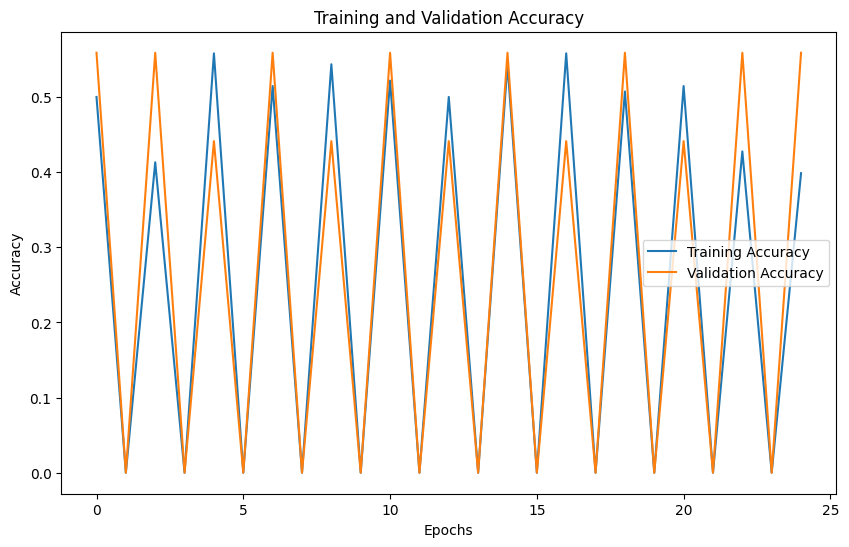

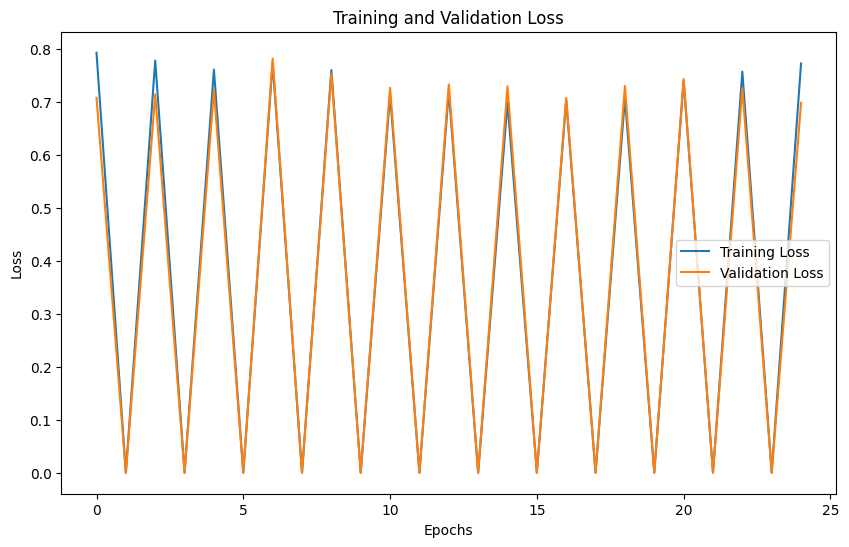

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

# Definir generadores de imágenes con aumento de datos
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Reservar 20% de los datos para validación
)

data_dir = 'db_unal/organized/images/cropped'

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary',
    subset='training'  # Especificar que esto es para el conjunto de entrenamiento
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=6,
    class_mode='binary',
    subset='validation'  # Especificar que esto es para el conjunto de validación
)

# Cargar modelo preentrenado
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar capas base
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuevas capas
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

# Calcular los steps per epoch y validation steps
train_steps = int(np.ceil(train_generator.samples / train_generator.batch_size))
val_steps = int(np.ceil(validation_generator.samples / validation_generator.batch_size))

# Entrenar el modelo
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=validation_generator,
    validation_steps=val_steps,
    epochs=25
)

# Retrieve accuracy results on training and validation data sets for each training epoch.
acc = history.history['accuracy']  # Training accuracy
val_acc = history.history['val_accuracy']  # Validation accuracy

# Retrieve loss results on training and validation data sets for each training epoch.
loss = history.history['loss']  # Training loss
val_loss = history.history['val_loss']  # Validation loss

# Determine the number of epochs, based on the length of the accuracy list.
epochs = range(len(acc))

# Plot training and validation accuracy as a function of epochs.
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')  # Set the title of the graph
plt.xlabel('Epochs')  # Label the x-axis as 'Epochs'
plt.ylabel('Accuracy')  # Label the y-axis as 'Accuracy'
plt.legend()  # Add a legend to distinguish training vs. validation

# Plot training and validation loss as a function of epochs.
plt.figure(figsize=(10, 6))  # Create a new figure for loss visualization
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')  # Set the title of the graph
plt.xlabel('Epochs')  # Label the x-axis as 'Epochs'
plt.ylabel('Loss')  # Label the y-axis as 'Loss'
plt.legend()  # Add a legend to distinguish training vs. validation

### **ResNet101**

## **EfficientNet**

## **VGG**

### **VGG16**

### **VGG19**

## **InceptionV3**

## **Xception**

## **DenseNet**